### Import Libraries

In [85]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Dropout, GlobalAveragePooling1D

#### Data Overview

In [86]:
df_data = pd.read_csv('text_clean.csv')

In [87]:
df_data.head()

,text_clean,sentiment
0,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus k 212 mmbri hujjah partai di...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus beli,positive
4,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [88]:
df_data[df_data['text_clean'].isnull()]

,text_clean,sentiment


In [89]:
len(df_data['sentiment'])

11000

### Tokenizing data

In [90]:
# Assign Tokenizer() ke tokenizer
tokenizer = Tokenizer()

# Fit tokenizer nya ke text
tokenizer.fit_on_texts(df_data['text_clean'])

# Dibuat sequence
sequence = tokenizer.texts_to_sequences(df_data['text_clean'])

# Assign hasil pad sequence dari data teks untuk training ke dalam variabel X
X = pad_sequences(sequence, maxlen=64) # Pad sequence nya, dibuat maxlen berdasarkan panjang maksimal karakter dalam satu baris kalimat di data_df

In [91]:
# Assign data sentimen sebagai target yang mau diprediksi ke dalam variabel y, diubah jadi array
y = df_data['sentiment'].values

In [92]:
print(X.shape)
print(y.shape)

(11000, 64)
(11000,)


In [93]:
# Pakai train_test_split buat bagi data train sama data test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, train_size=0.75, shuffle=True)

In [94]:
# Iseng aja mau liat shape nya sekarang

print('X_train: ')
print(X_train.shape)
print('')
print('X_test: ')
print(X_test.shape)
print('')
print('y_train: ')
print(y_train.shape)
print('')
print('y_test: ')
print(y_test.shape)
print('')



X_train: 
(8250, 64)

X_test: 
(2750, 64)

y_train: 
(8250,)

y_test: 
(2750,)



In [95]:
y_train

array(['neutral', 'neutral', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

In [82]:
X_train

array([[   0,    0,    0, ..., 5511,  713, 1953],
       [   0,    0,    0, ..., 1117,  491, 4841],
       [   0,    0,    0, ...,  350,  559, 1778],
       ...,
       [   0,    0,    0, ...,  112, 1781,   61],
       [   0,    0,    0, ...,  590,  150,   10],
       [   0,    0,    0, ...,   39,   27,  232]])

In [96]:
# Kita ubah shape y nya biar jadi array 2D kaya X

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [99]:
print(y_train.shape)

(8250, 1)


In [114]:
# Pakai OneHotEncoder
onehot = OneHotEncoder()
y_tr_hot = onehot.fit_transform(y_train).toarray() # Balikin lagi bentuknya ke array
y_tt_hot = onehot.fit_transform(y_test).toarray()

In [115]:
print(y_tr_hot)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [75]:
print('X_train:', X_train)
print('X_test:', X_test)

X_train: [[   0    0    0 ... 5511  713 1953]
 [   0    0    0 ... 1117  491 4841]
 [   0    0    0 ...  350  559 1778]
 ...
 [   0    0    0 ...  112 1781   61]
 [   0    0    0 ...  590  150   10]
 [   0    0    0 ...   39   27  232]]
X_test: [[   0    0    0 ... 3790   18 3338]
 [   0    0    0 ...    2  642  237]
 [   0    0    0 ...  371  132  731]
 ...
 [   0    0    0 ...    9 1330   65]
 [   0    0    0 ...    0  196 5914]
 [   0    0    0 ...    3  126    6]]


In [76]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_tr_hot:', y_tr_hot.shape)
print('y_tt_hot:', y_tt_hot.shape)

X_train: (8250, 64)
X_test: (2750, 64)
y_tr_hot: (8250, 3)
y_tt_hot: (2750, 3)


### Model NN

In [58]:
# Kita pakai keras sequential untuk modelnya
model = tf.keras.Sequential([

    # Pakai layer embedding, isinya max_features, output_dim, dan input_shape
    tf.keras.layers.Embedding(15000, 128, input_shape=(64,)),

    # Layer GlobalAveragePooling1D ngubah input biar sesuai sama output
    # tf.keras.layers.GlobalAveragePooling1D(),

    # Layer Flatten biar data inputnya dikalikan sama output_dim
    tf.keras.layers.Flatten(),

    # Layer Dense
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Assign loss function yang mau dipakai ke dalam variabel loss_fn
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Assign optimizer yang mau dipakai ke dalam variabel (sgd karena pakai optimizer SGD), learning rate bisa ditunning untuk cari hasil yg lebih bagus
sgd = tf.keras.optimizers.SGD(learning_rate=0.0005)

# Bikin kondisi untuk early stopping berdasarkan parameter yang dimonitor
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='min',
    verbose=1,
    patience=80,
    restore_best_weights=True)

# Compile model
model.compile(loss=loss_fn, optimizer=sgd, metrics=['accuracy'])

# Menampilkan summary dari model yang udah dibuah
model.summary()

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 64, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,446,531 (9.33 MB)

 Trainable params: 2,446,531 (9.33 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Assign nilai epoch ke dalam n_epoch, gak diassign pun gak apa apa, langsung masuk di model fit
n_epochs = 100

# Simpan hasil model fit nya ke dalam history, supaya bisa pakai hasil training yang paling bagus setelah proses training
history = model.fit(X_train, y_tr_hot, epochs=n_epochs,
                    validation_data=(X_test, y_tt_hot), callbacks=[es], batch_size=64)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5801 - loss: 1.0773 - val_accuracy: 0.5902 - val_loss: 1.0559
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5805 - loss: 1.0508 - val_accuracy: 0.5905 - val_loss: 1.0296
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5886 - loss: 1.0252 - val_accuracy: 0.5905 - val_loss: 1.0066
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5775 - loss: 1.0075 - val_accuracy: 0.5905 - val_loss: 0.9867
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5769 - loss: 0.9889 - val_accuracy: 0.5905 - val_loss: 0.9695
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5821 - loss: 0.9716 - val_accuracy: 0.5905 - val_loss: 0.9551
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5866 - loss: 0.9565 - val_accuracy: 0.5905 - val_loss: 0.9431
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5863 - loss: 0.9450 - va

In [60]:
# Panggil history dari model fitting tadi pakai fungsi history
result = history.history

# Define num_epochs buat keperluan visualisasi
num_epochs = np.arange(0, len(result['accuracy']))

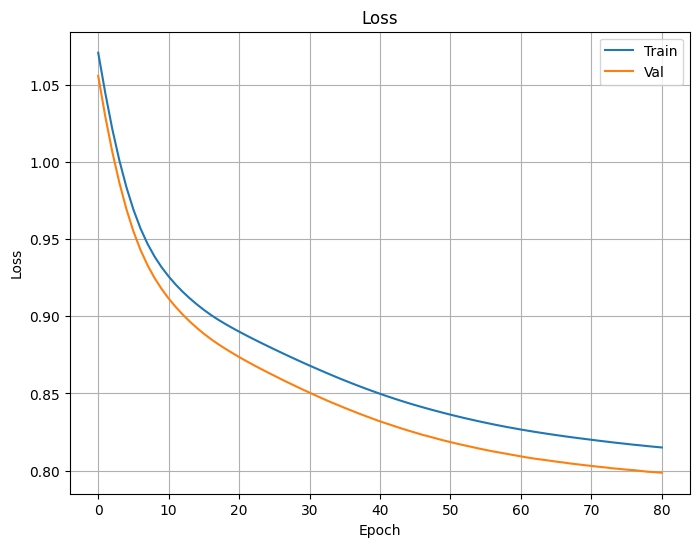

In [61]:
# Visualisasi hasil training dan evaluasinya
plt.figure(figsize=(8,6))
plt.title('Loss')
plt.plot(num_epochs, result['loss'])
plt.plot(num_epochs, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [65]:
# Predict pakai data test atau data eval
y_pred_test = model.predict(X_test)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [66]:
# Ngecek f1 score
matrix_test = metrics.classification_report(y_tt_hot.argmax(axis=1), y_pred_test.argmax(axis=1))
print(matrix_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       854
           1       0.00      0.00      0.00       272
           2       0.59      1.00      0.74      1624

    accuracy                           0.59      2750
   macro avg       0.20      0.33      0.25      2750
weighted avg       0.35      0.59      0.44      2750



c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [228]:
print(y_pred_test[0])
print(y_pred.numpy()[0])

[0.33234888 0.2555868  0.41206434]
2


In [229]:
print(X_tr.shape, X_tt.shape)
print(y_tr_hot.shape, y_tt_hot.shape)

(8250, 70) (2750, 70)
(8250, 3) (2750, 3)


### LSTM

In [68]:
embed_dim = 128
lstm_out = 32
model_lstm = Sequential()
model_lstm.add(Embedding(15000, embed_dim,input_length = X_train.shape[1]))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(lstm_out, dropout=0.2))
model_lstm.add(Dense(3, activation='softmax'))
               
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

model_lstm.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['accuracy'])
model_lstm.summary()

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
n_epochs = 70
history_lstm = model_lstm.fit(X_train, y_tr_hot, epochs=n_epochs,
                    validation_data=(X_test, y_tt_hot), callbacks=[es], batch_size=64)

Epoch 1/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5594 - loss: 1.0073 - val_accuracy: 0.5905 - val_loss: 0.9022
Epoch 2/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5723 - loss: 0.9130 - val_accuracy: 0.5905 - val_loss: 0.8721
Epoch 3/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5831 - loss: 0.8766 - val_accuracy: 0.6269 - val_loss: 0.8261
Epoch 4/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6264 - loss: 0.8279 - val_accuracy: 0.6727 - val_loss: 0.7961
Epoch 5/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6589 - loss: 0.8060 - val_accuracy: 0.6836 - val_loss: 0.7884
Epoch 6/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6575 - loss: 0.7983 - val_accuracy: 0.6895 - val_loss: 0.7880
Epoch 7/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.6571 - loss: 0.8127 - val_accuracy: 0.6898 - val_loss: 0.7771
Epoch 8/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6750 - loss: 0.7878 - val_accu

In [71]:
result1 = history_lstm.history
num_ep = np.arange(0, len(result['accuracy']))

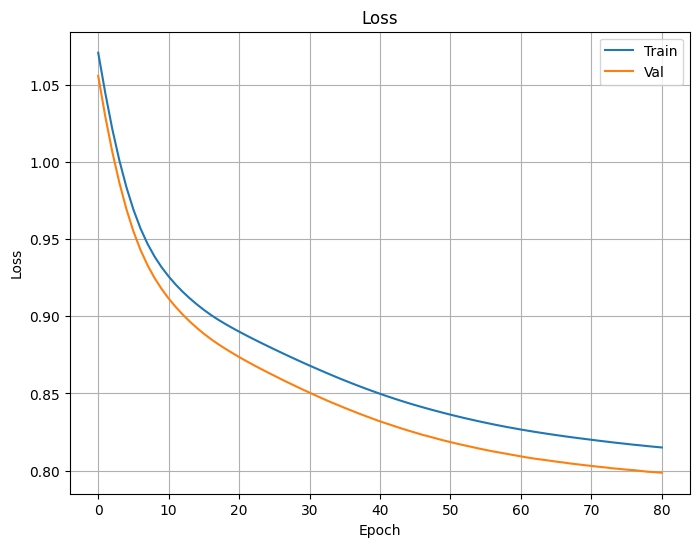

In [72]:
plt.figure(figsize=(8,6))
plt.title('Loss')
plt.plot(num_ep, result['loss'])
plt.plot(num_ep, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [73]:
y_pred_test_lstm = model_lstm.predict(X_test)

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [74]:
matrix_test_lstm = metrics.classification_report(y_tt_hot.argmax(axis=1), y_pred_test_lstm.argmax(axis=1))
print(matrix_test_lstm)

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       854
           1       1.00      0.10      0.19       272
           2       0.92      0.89      0.90      1624

    accuracy                           0.81      2750
   macro avg       0.86      0.62      0.61      2750
weighted avg       0.84      0.81      0.78      2750

